In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas
import pointprocesses as ppr

In [8]:
import torch

# Données synthétiques

In [3]:
def intensity_function_(t, lam0, alpha, beta, history):
    return lam0 + np.sum(alpha*beta*np.exp(-beta*(t - history))*(t >= history), axis=0)

intensity_function = np.vectorize(intensity_function_, excluded={4})

In [4]:
import itertools
mu = 1.0
tmax = 20.0
alpha = 0.2
beta  = 2.0

print("Expected avg evt no. %.3f" % (tmax*mu/(1.-alpha)))

Expected avg evt no. 25.000


In [5]:
n_traj = 10
sample_trajectories = [ppr.hawkes_exp(tmax, beta, mu, itertools.repeat(alpha)) for _ in range(n_traj)]

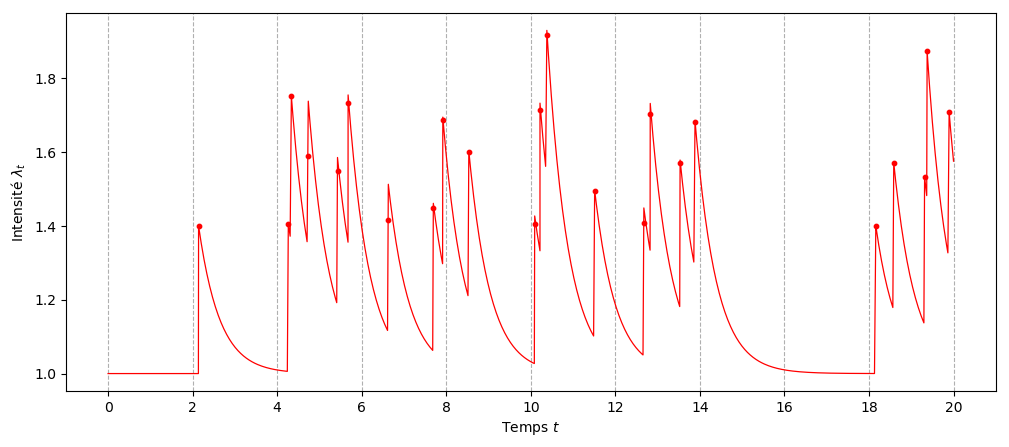

In [6]:
one_traj = sample_trajectories[0]
fig, ax = plt.subplots(1,1, figsize=(12,5), dpi=100)
ax.set_xlabel("Temps $t$")
ax.set_ylabel(r"Intensité $\lambda_t$")
t_arr = np.sort(np.append(np.linspace(0, tmax, 600), one_traj[:,]))
ax.plot(t_arr, intensity_function(t_arr, mu, alpha, beta, one_traj[:,0]), 'r-', linewidth=0.9)
ax.xaxis.set_major_locator(mticker.MultipleLocator(2.))
scatter_opts = {
    "c": "r", "s": 11
}
ax.grid(True, axis='x', linestyle='--')
ax.scatter(one_traj[:,0], one_traj[:,1], c='r', s=10)

We will pad each sequence with 0s at the end.

In [9]:
input_size = max(s.shape[0] for s in sample_trajectories)
print("Input size (max. trajectory length): %d" % input_size)
length_array = [s.shape[0] for s in sample_trajectories]
data_array = np.stack([np.pad(s[:,0], ((0, input_size - s.shape[0])), 'constant') for s in sample_trajectories])
data_array = data_array.transpose()
data_tensor = torch.from_numpy(data_array).to(torch.float32)

Input size (max. trajectory length): 36


In [10]:
length_array

[23, 25, 30, 36, 32, 21, 19, 27, 26, 32]

The first dimension is for time, the second for the sample.

## Neural net

In [11]:
import torch
import torch.nn as nn
from torch import optim

In [12]:
device = torch.device("cpu")
print(device)

cpu


In [13]:
torch.manual_seed(1)

$$
    \lambda_k(t) = f_k(\mathbf w_k^\intercal\mathbf h(t))
$$

$$
    \mathbf h(t) = \mathbf o_i \odot \tanh(\mathbf c(t))\in\mathbb R^D,\quad t\in(t_{i-1}, t_i]
$$

In [20]:
from model import NeuralCTLSTM

In [21]:
nhlstm = NeuralCTLSTM(10)
optimizer = optim.SGD(nhlstm.parameters(), lr=0.0001)

# We use mini-batches to train on our data
BATCH_SIZE = 10
print("Batch size: %d" % BATCH_SIZE)
print("Training sample size: %d" % data_tensor.size(1))
split_into_batches = data_tensor.split(BATCH_SIZE, dim=1)
num_of_batches = len(split_into_batches)
print("No. of batches: %d" % num_of_batches)

Batch size: 10
Training sample size: 10
No. of batches: 1


In [22]:
def train(num_of_batches):
    nhlstm.zero_grad()
    for i in range(num_of_batches):
        event_times = split_into_batches[i]
        feed_data = event_times[:-1] - event_times[1:] # transform into inter-arrival times
        print("Running batch %d, size %d." % (i, feed_data.size(1)), end=' ')
        output_hist = []
        hidden_hist = []
        cell_hist = []
        cell_target_hist = []
        decay_hist = []
        nhlstm.init_hidden(feed_data.size(1))
        for i in range(feed_data.size(0)):
            output, hidden, ct, cbar, decay_t = nhlstm(feed_data[i])
            output_hist.append(output)
            hidden_hist.append(hidden)
            cell_hist.append(ct)
            cell_target_hist.append(cbar)
            decay_hist.append(decay_t)
        output_hist = torch.stack(output_hist)
        hidden_hist = torch.stack(hidden_hist)
        cell_hist = torch.stack(cell_hist)
        cell_target_hist = torch.stack(cell_target_hist)
        decay_hist = torch.stack(decay_hist)

        loss = nhlstm.likelihood(event_times, cell_hist, cell_target_hist, output_hist, decay_hist, tmax)
        print("Loss: %.5f" % loss.item())
        loss.backward()  # compute the gradients
        optimizer.step() # do a step of the SGD algorithm

train(1)

Running batch 0, size 10. > /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(147)likelihood()
-> inter_times = event_times[-1:] - event_times[1:]


(Pdb)  
(Pdb)  
(Pdb)  
(Pdb)  next


> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(150)likelihood()
-> self.eval_intensity(inter_times[i], output[i],


(Pdb)  next


> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(152)likelihood()
-> for i in range(inter_times.size(0))


(Pdb)  next


> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(154)likelihood()
-> event_intensities = torch.stack(event_intensities)


(Pdb)  next


> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(155)likelihood()
-> first_sum = event_intensities.log().sum(dim=0)


(Pdb)  event_intensities.shape


torch.Size([35, 1, 10])


(Pdb)  event_times.shape


torch.Size([36, 10])


(Pdb)  inter_times.shape


torch.Size([35, 10])


(Pdb)  next


> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(158)likelihood()
-> batch_size = output.size(1)


(Pdb)  first_sum.shape


torch.Size([1, 10])


(Pdb)  s


> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(160)likelihood()
-> samples, _ = (T * torch.rand(event_times.size(0), batch_size)).sort(0)


(Pdb)  s


> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(162)likelihood()
-> mask_idx = torch.cumsum((samples >= event_times), dim=0)


(Pdb)  s


> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(163)likelihood()
-> mask_idx = mask_idx[:-1]


(Pdb)  mask_idx.shape


torch.Size([36, 10])


(Pdb)  s


> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(165)likelihood()
-> dsamples = samples[:-1] - samples[1:]


(Pdb)  mask_idx.shape


torch.Size([35, 10])


(Pdb)  s


> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(166)likelihood()
-> ioutput = output[mask_idx]


(Pdb)  dsamples.shape


torch.Size([35, 10])


(Pdb)  s


> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(167)likelihood()
-> ic_ti = c_ti[mask_idx]


(Pdb)  ioutput.shape


torch.Size([35, 10, 10, 10])


(Pdb)  s


> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(168)likelihood()
-> icbar = cbar[mask_idx]


(Pdb)  break
(Pdb)  break
(Pdb)  uù


*** Invalid frame count (ù)


(Pdb)  u


> <ipython-input-22-3b8a8f9b75e2>(26)train()
-> loss = nhlstm.likelihood(event_times, cell_hist, cell_target_hist, output_hist, decay_hist, tmax)


(Pdb)  u


> <ipython-input-22-3b8a8f9b75e2>(31)<module>()
-> train(1)


(Pdb)  s


> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(169)likelihood()
-> idecay = decay[mask_idx]


(Pdb)  s


> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(170)likelihood()
-> lam_samples = torch.stack([


(Pdb)  s


> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(171)likelihood()
-> self.eval_intensity(dsamples[i], ioutput[i],


(Pdb)  s


> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(173)likelihood()
-> for i in range(output.size(0))


(Pdb)  s


--Call--
> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(171)<listcomp>()
-> self.eval_intensity(dsamples[i], ioutput[i],


(Pdb)  s


> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(171)<listcomp>()
-> self.eval_intensity(dsamples[i], ioutput[i],


(Pdb)  s


> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(173)<listcomp>()
-> for i in range(output.size(0))


(Pdb)  s


--Call--
> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(113)eval_intensity()
-> def eval_intensity(self, dt, output, c_ti, cbar, decay):


(Pdb)  s


> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(125)eval_intensity()
-> c_t_after = self.c_func(dt, c_ti, cbar, decay)


(Pdb)  s


--Call--
> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(50)c_func()
-> def c_func(self, dt: torch.Tensor, c: torch.Tensor,


(Pdb)  s


> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(59)c_func()
-> dt = dt.unsqueeze(-1)


(Pdb)  c_t_after.shape


*** NameError: name 'c_t_after' is not defined


(Pdb)  dt.shape


torch.Size([10])


(Pdb)  s


> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(61)c_func()
-> return cbar + (c - cbar) * torch.exp(-decay * dt)


(Pdb)  s


--Return--
> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(61)c_func()->tensor([[[  0...hAddBackward>)
-> return cbar + (c - cbar) * torch.exp(-decay * dt)


(Pdb)  s


> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(126)eval_intensity()
-> h_t = output * torch.tanh(c_t_after)


(Pdb)  h_t.shape


*** NameError: name 'h_t' is not defined


(Pdb)  s


> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(127)eval_intensity()
-> try:


(Pdb)  h_t.shape


torch.Size([10, 10, 10])


(Pdb)  s


> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(128)eval_intensity()
-> pre_lambda = torch.mm(self.weight_f[None, :], h_t.t())


(Pdb)  s


RuntimeError: t() expects a 2D tensor, but self is 3D
> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(128)eval_intensity()
-> pre_lambda = torch.mm(self.weight_f[None, :], h_t.t())


(Pdb)  s


> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(129)eval_intensity()
-> except BaseException:


(Pdb)  pre_lambda.shape


*** NameError: name 'pre_lambda' is not defined


(Pdb)  s


> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(130)eval_intensity()
-> print("Error occured in c_func")


(Pdb)  s


--Call--
> /home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel/iostream.py(382)write()
-> def write(self, string):


(Pdb)  s


> /home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel/iostream.py(383)write()
-> if self.echo is not None:


(Pdb)  s


> /home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel/iostream.py(391)write()
-> if self.pub_thread is None:


(Pdb)  s


> /home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel/iostream.py(395)write()
-> if not isinstance(string, unicode_type):


(Pdb)  s


> /home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel/iostream.py(398)write()
-> is_child = (not self._is_master_process())


(Pdb)  n


> /home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel/iostream.py(400)write()
-> self.pub_thread.schedule(lambda : self._buffer.write(string))


(Pdb)  n


Error occured in c_func> /home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel/iostream.py(401)write()
-> if is_child:


(Pdb)  n


> /home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel/iostream.py(408)write()
-> self._schedule_flush()


(Pdb)  continue



 dt shape torch.Size([10])
 Weights shape torch.Size([10])
 h_t shape torch.Size([10, 10, 10])


RuntimeError: t() expects a 2D tensor, but self is 3D